In [ ]:
# ECG Model Interactive Debugging Notebook
# This notebook allows you to debug flat line predictions by monitoring training components

import os
import sys
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader,ConcatDataset
from types import SimpleNamespace

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Setup paths - adjust ROOT_DIR to your project root
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/fl4tsf'
BIN_DIR = f'{ROOT_DIR}/bin'
DATA_DIR = f'{ROOT_DIR}/data'
import os
import sys
sys.path.append(ROOT_DIR)
sys.path.append(BIN_DIR)
# Add bin directory to path and change working directory
os.chdir(BIN_DIR)


# Add bin directory to path and change working directory
sys.path.append(BIN_DIR)
os.chdir(BIN_DIR)

# Import modules
from flower.task import Net
from flower.model_config import get_model_config
from lib.physionet import variable_time_collate_fn, get_data_min_max
from lib import utils
from lib.collate_functions import basic_collate_fn
from lib.plot import plot_trajectories
from lib import losses
from lib.create_latent_ode_model import create_LatentODE_model
from lib.base_models import VAE_Baseline
from lib.utils import init_network_weights
from lib.losses import get_frequency_loss
# Configure matplotlib for inline plotting


# ==========================================
# CONFIGURATION SECTION
# ==========================================
CONFIG = {
    'model_name': 'rnn_vae',  # Adjust model name as needed
    'dataset_type': 'periodic', # Add this line periodic or ecg
    'id': 'sin_debug',
    'dataset_name': 'periodic', # Adjust dataset name as needed
    'data_folder': '.',
    'lr': 0.01,
    'lrdecay': 1,
    'batch_size': 64,
    'sample_tp': 1,
    'cut_tp': 'false',
    'extrap': 'false',
    'gradientclipping': 'True',
    'storeweights': 'false',
    'obsrv_std': 0.01,
    'poisson': 'false',
    'rec_layers': 1,
    'gen_layers': 1,
    'units': 100,
    'gru_units': 100,
    'latents': 10,
    'rec_dims': 20,
    'z0_encoder': 'odernn',
    'train_classif_w_reconstr': 'false',
    'classif': 'false',
    'linear_classif': 'false',
    'classif_per_tp': 'false',
    'n_labels': 1,
    'input_dim': 1, # Adjust
    'epochs': 500,
    'solver_method': 'dopri5', # Adjust if needed
    'encoder_solver_method': 'dopri5',
    'use_jit': 'false',
    'ode_rtol': '1e-5',
    'ode_atol': '1e-5'
}

# Data paths for the periodic dataset
CLIENT_ID = 0
DATA_BASE_DIR = os.path.join(ROOT_DIR, 'data', 'periodic') # Adjust
DATASET_NAME = CONFIG['dataset_name']

In [ ]:
# ==========================================
# SETUP FUNCTIONS
# ==========================================

def create_model_config():
    """Create temporary model.config file with debugging configuration"""
    config_path = os.path.join(BIN_DIR, 'model.config')
    with open(config_path, 'w') as f:
        for key, value in CONFIG.items():
            f.write(f"{key},{value}\n")
    print(f"Created model config at: {config_path}")
    return config_path

def load_data(client_id=0, time = 100):
    """
    Load data for a specific client, adapting to the dataset type.
    """
    dataset_type = CONFIG.get('dataset_type', 'ecg')
    
    # Construct the full path to the specific dataset directory
    dataset_dir = os.path.join(DATA_BASE_DIR, DATASET_NAME)
    print(f"Loading data of type '{dataset_type}' from: {dataset_dir}")

    # Common file paths
    train_path = os.path.join(dataset_dir, f'client_{client_id}_train.pt')
    test_path = os.path.join(dataset_dir, f'client_{client_id}_test.pt')
    
    # Load datasets
    train_dataset = torch.load(train_path, weights_only=False)[:,0:time,:]
    test_dataset = torch.load(test_path, weights_only=False)[:,0:time,:]

    # Initialize return values
    data_min, data_max, time_steps = None, None, None

    if dataset_type == 'ecg':
        # data requires data_min and data_max for normalization
        data_min_path = os.path.join(dataset_dir, f'client_{client_id}_data_min.pt')
        data_max_path = os.path.join(dataset_dir, f'client_{client_id}_data_max.pt')
        data_min = torch.load(data_min_path, weights_only=False)
        data_max = torch.load(data_max_path, weights_only=False)
        # For, time steps are part of the data tuples, not a separate file
        
    elif dataset_type == 'periodic':
        # Periodic data requires an external time_steps tensor
        time_steps_path = os.path.join(dataset_dir, f'client_{client_id}_time_steps_train.pt')
        time_steps = torch.load(time_steps_path, weights_only=False)[0][0:time]
        # Min/max normalization is not typically used for this dataset
    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    return train_dataset, test_dataset, data_min, data_max, time_steps

def create_dataloaders(train_dataset, test_dataset, data_min, data_max, time_steps, batch_size=16):
    """Create dataloaders with the appropriate collate function."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset_type = CONFIG.get('dataset_type', 'ecg')

    if dataset_type == 'ecg':
        args_collate = SimpleNamespace(sample_tp=CONFIG['sample_tp'], cut_tp=None, extrap=None)
        collate_fn_train = lambda batch: variable_time_collate_fn(
            batch, args_collate, device, data_type="train", data_min=data_min, data_max=data_max
        )
        collate_fn_test = lambda batch: variable_time_collate_fn(
            batch, args_collate, device, data_type="test", data_min=data_min, data_max=data_max
        )
    elif dataset_type == 'periodic':
        collate_fn_train = lambda batch: basic_collate_fn(
            batch, time_steps, CONFIG['dataset_name'], CONFIG['sample_tp'], None, False, device, data_type="train"
        )
        collate_fn_test = lambda batch: basic_collate_fn(
            batch, time_steps, CONFIG['dataset_name'], CONFIG['sample_tp'], None, False, device, data_type="test"
        )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_train)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_test)
    
    return train_loader, test_loader

def plot_reconstructions(batch_dict, pred_y, n_samples=3):
    """Generic function to plot reconstructions vs ground truth,
    excluding masked (zero) values from ground truth and predictions."""

    truth = batch_dict["data_to_predict"]
    observed_data = batch_dict["observed_data"]
    observed_tp = batch_dict["observed_tp"]
    time_pred = batch_dict["tp_to_predict"]
    mask_predicted_data = batch_dict["mask_predicted_data"] # Get the mask for predicted data
    
    n_samples = min(n_samples, truth.shape[0])
    n_features = min(3, truth.shape[2]) # Plot up to 3 features

    fig, axes = plt.subplots(n_samples, n_features, figsize=(15, 4*n_samples), squeeze=False)
    
    for i in range(n_samples):
        for j in range(n_features):
            ax = axes[i, j]
            if "observed_mask" in batch_dict and batch_dict["observed_mask"] is not None:
                current_observed_mask = batch_dict["observed_mask"][i, :, j].cpu()
                valid_observed_indices = current_observed_mask == 1
                ax.scatter(observed_tp.cpu()[valid_observed_indices], 
                           observed_data[i, valid_observed_indices, j].cpu(), 
                           c='blue', s=10, alpha=0.3, label='Observed', zorder=3)
            else:
                # Fallback if no explicit observed_mask is provided in batch_dict
                # This plots all points in observed_data; if it contains padded zeros, they'll be plotted.
                ax.scatter(observed_tp.cpu(), observed_data[i, :, j].cpu(), 
                           c='blue', s=10, alpha=0.3, label='Observed', zorder=3)
            

            # Ground truth trajectory - plot only valid points
            ax.plot(time_pred.cpu(), truth[i, :, j].cpu(), 
                    'g-', linewidth=2, alpha=0.5, label='Ground Truth')
            
            # Plot predicted points - plot only valid points
            ax.plot(time_pred.cpu(), pred_y[0, i, :, j].cpu(),
                    marker='x',          # Use a marker instead of a line
                    color='red',         # Set color to red
                    linestyle='none',    # Remove the connecting line
                    markersize=5,        # Adjust marker size for visibility
                    alpha=0.8, 
                    label='Predicted Points')
            
            ax.set_title(f'Sample {i}, Feature {j}')
            if i == 0 and j == 0:
                ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Time')
            ax.set_ylabel('Value')
            
    plt.tight_layout()
    plt.show()

# ==========================================
# DEBUGGING FUNCTIONS
# ==========================================

def detailed_training_step(model, batch_dict, optimizer, kl_coef=1.0):
    """Perform one training step with detailed loss breakdown for time series reconstruction"""
    optimizer.zero_grad()
    
    # Forward pass to get predictions
    pred_y, info = model.get_reconstruction(
        batch_dict["tp_to_predict"], 
        batch_dict["observed_data"], 
        batch_dict["observed_tp"],
        mask=batch_dict["observed_mask"], 
        n_traj_samples=3,
        mode=batch_dict["mode"]
    )
        
    results = model.compute_all_losses(batch_dict, kl_coef=kl_coef)
    loss = results["loss"]

    # Backward pass
    loss.backward()
    
    # --- INSERT GRADIENT CHECK ---
    # print(f"\n===== Gradient Check =====")
    # check_gradients(model.diffeq_solver.ode_func.gradient_net, "ODEFunc Network")
    # check_gradients(model.decoder, "Decoder")
    # check_gradients(model.encoder_z0, "Encoder")

    # Clip gradients if enabled in config
    if CONFIG['gradientclipping'] == 'True':
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        
    optimizer.step()
    
    # Extract detailed metrics for time series reconstruction
    # Use .get() for ODE-specific metrics to avoid errors with other models
    metrics = {
        'total_loss': loss.item(),
        'reconstruction_loss': -results["likelihood"].item(),  # Negative log likelihood
        'kl_divergence': results.get("kl_first_p", 0), # Use .get() for safety
        'mse': results["mse"].item(),
        'nodesolve': results.get("nodesolve", 0), # Use .get() for safety
        'fp_std': results.get("std_first_p", 0) # Use .get() for safety
    }
    
    return metrics

def get_model_predictions(model, batch_dict):
    """Get model predictions and latent representations"""
    model.eval()
    with torch.no_grad():
        # Get reconstructions
        pred_y, info = model.get_reconstruction(
            batch_dict["tp_to_predict"], 
            batch_dict["observed_data"], 
            batch_dict["observed_tp"],
            mask=batch_dict["observed_mask"],
            n_traj_samples=1
        )
        
        # Extract latent trajectory if available
        latent_traj = info.get("latent_traj", None)
        first_point = info.get("first_point", (None, None, None))
        
    model.train()
    return pred_y, latent_traj, first_point


def plot_predictions_vs_truth(batch_dict, pred_y, n_samples=2):
    """Plot model predictions vs ground truth - FIXED VERSION"""
    truth = batch_dict["data_to_predict"]
    time_pred = batch_dict["tp_to_predict"]
    
    n_samples = min(n_samples, truth.shape[0])
    n_features = min(3, truth.shape[2])
    
    fig, axes = plt.subplots(n_samples, n_features, figsize=(15, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    if n_features == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(n_samples):
        for j in range(n_features):
            ax = axes[i, j]
            
            # Plot truth and predictions
            truth_vals = truth[i, :, j].cpu()
            pred_vals = pred_y[0, i, :, j].cpu()  # [n_traj_samples, batch, time, features]
            times = time_pred.cpu()  # FIX: Don't index by sample - time_pred is shared across batch
            
            ax.plot(times, truth_vals, 'b-', label='Truth', alpha=0.7, linewidth=2)
            ax.plot(times, pred_vals, 'r--', label='Prediction', alpha=0.7, linewidth=2)
            
            ax.set_title(f'Sample {i}, Feature {j}')
            if i == 0 and j == 0:
                ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Time')
            ax.set_ylabel('Value')
    
    plt.tight_layout()
    plt.show()

def check_gradients(model, model_name="Model"):
    """Prints the mean and max gradient values for a model's parameters."""
    print(f"\n--- Gradients for {model_name} ---")
    total_norm = 0
    for name, parameter in model.named_parameters():
        if parameter.grad is not None:
            grad_abs = torch.abs(parameter.grad.detach())
            print(f"{name:<30} | grad_mean: {grad_abs.mean():.2e} | grad_max: {grad_abs.max():.2e}")
            total_norm += parameter.grad.detach().norm(2).item()**2
        else:
            print(f"{name:<30} | grad: None")
    print(f"Total L2 Norm of Gradients: {total_norm**0.5:.2e}")
    
def plot_latent_trajectories(latent_traj, time_steps, n_samples=2):
    """Plot latent space trajectories"""
    if latent_traj is None:
        print("No latent trajectories available")
        return
    
    # latent_traj shape: [n_traj_samples, batch, time, latent_dim]
    n_samples = min(n_samples, latent_traj.shape[1])
    n_latent = min(10, latent_traj.shape[3])  # Plot first 10 latent dimensions
    
    fig, axes = plt.subplots(n_samples, n_latent, figsize=(20, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    if n_latent == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(n_samples):
        for j in range(n_latent):
            ax = axes[i, j]
            
            latent_vals = latent_traj[0, i, :, j].cpu()  # First trajectory sample
            times = time_steps.cpu()
            
            ax.plot(times, latent_vals, 'g-', alpha=0.7)
            ax.set_title(f'Latent Dim {j}')
            ax.set_xlabel('Time')
            if j == 0:
                ax.set_ylabel('Latent Value')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ==========================================
# MAIN DEBUGGING PIPELINE
# ==========================================

def debug_training_pipeline():
    """Main debugging function that runs a complete training pipeline with monitoring"""
    
    print("=== Model Debugging Pipeline ===\n")
    
    # 1. Setup
    print("1. Setting up configuration...")
    config_path = create_model_config()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
 # 2. Load data
    print("\n2. Loading data...")
    # Pass CLIENT_ID to the updated function
    train_dataset, test_dataset, data_min, data_max, time_steps = load_data(client_id=CLIENT_ID) 
    train_loader, test_loader = create_dataloaders(
        train_dataset, test_dataset, data_min, data_max, time_steps, CONFIG['batch_size']
    )
    # 3. Initialize model
    print("\n3. Initializing model...")
    model = Net()
    model.to(device)
    print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
    
    # 4. Setup optimizer
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'])
    
    # 5. Inspect a sample batch
    sample_batch = next(iter(train_loader))
    
    # 6. Check initial predictions
    print("\n5. Checking initial predictions (before training)...")
    pred_y, latent_traj, first_point = get_model_predictions(model, sample_batch)
    plot_reconstructions(sample_batch, pred_y, n_samples=2)
    plot_latent_trajectories(latent_traj, sample_batch["tp_to_predict"], n_samples=2)
    
    # 7. Training loop with monitoring
    print("\n6. Starting training with detailed monitoring...")
    
    n_epochs = CONFIG['epochs']
    n_batches = len(train_loader)
    
    # Tracking variables
    train_metrics = []
    kl_coef = 0.0  # Start with no KL penalty
    
    for epoch in range(n_epochs):
        model.train()
        epoch_metrics = []
        
        # KL annealing schedule
        if epoch >= 50:  # Start KL after 10 epochs
            kl_coef = min(1.0, (epoch - 50) / 50.0)  # Gradually increase to 1.0
        
        train_loader_inf = utils.inf_generator(train_loader)
        
        for batch_idx in range(n_batches):
            batch_dict = next(train_loader_inf)
            
            # Detailed training step
            metrics = detailed_training_step(model, batch_dict, optimizer, kl_coef)
            metrics['epoch'] = epoch
            metrics['batch'] = batch_idx
            metrics['kl_coef'] = kl_coef
            epoch_metrics.append(metrics)
            
            # Print progress for time series reconstruction
            if batch_idx % max(1, n_batches // 5) == 0:
                print(f"Epoch {epoch}, Batch {batch_idx}/{n_batches}: "
                      f"Loss={metrics['total_loss']:.4f}, "
                      f"Recon={metrics['reconstruction_loss']:.4f}, "
                      f"KL={metrics['kl_divergence']:.4f}, "
                      f"MSE={metrics['mse']:.4f}, "
                      f"FP_std={metrics['fp_std']:.4f}")
        
        train_metrics.extend(epoch_metrics)
        
        # Plot reconstructions
        print(f"\n--- Epoch {epoch} Reconstructions ---")
        pred_y, latent_traj, first_point = get_model_predictions(model, sample_batch)
        plot_reconstructions(sample_batch, pred_y, n_samples=2)
        plot_latent_trajectories(latent_traj, sample_batch["tp_to_predict"], n_samples=2)

    # 8. Plot training curves for time series reconstruction
    print("\n7. Plotting reconstruction training curves...")
    df_metrics = pd.DataFrame(train_metrics)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Total loss
    axes[0, 0].plot(df_metrics['epoch'] + df_metrics['batch']/n_batches, df_metrics['total_loss'])
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Reconstruction vs KL
    axes[0, 1].plot(df_metrics['epoch'] + df_metrics['batch']/n_batches, df_metrics['reconstruction_loss'], label='Reconstruction')
    axes[0, 1].plot(df_metrics['epoch'] + df_metrics['batch']/n_batches, df_metrics['kl_divergence'], label='KL Divergence')
    axes[0, 1].set_title('Loss Components')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # MSE
    axes[0, 2].plot(df_metrics['epoch'] + df_metrics['batch']/n_batches, df_metrics['mse'])
    axes[0, 2].set_title('MSE (Reconstruction Error)')
    axes[0, 2].set_ylabel('MSE')
    axes[0, 2].grid(True, alpha=0.3)
    
    # KL coefficient
    axes[1, 0].plot(df_metrics['epoch'] + df_metrics['batch']/n_batches, df_metrics['kl_coef'])
    axes[1, 0].set_title('KL Coefficient (Annealing)')
    axes[1, 0].set_ylabel('KL Coef')
    axes[1, 0].grid(True, alpha=0.3)
    
    # First point std (latent space uncertainty)
    axes[1, 1].plot(df_metrics['epoch'] + df_metrics['batch']/n_batches, df_metrics['fp_std'])
    axes[1, 1].set_title('Latent Initial State Std')
    axes[1, 1].set_ylabel('Std')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Node solves (ODE solver steps)
    if 'nodesolve' in df_metrics.columns:
        axes[1, 2].plot(df_metrics['epoch'] + df_metrics['batch']/n_batches, df_metrics['nodesolve'])
        axes[1, 2].set_title('ODE Solver Steps')
        axes[1, 2].set_ylabel('Steps')
        axes[1, 2].grid(True, alpha=0.3)
    
    for ax in axes.flat:
        ax.set_xlabel('Epoch')
    
    plt.tight_layout()
    plt.show()
    
    # 9. Final evaluation
    print("\n8. Final evaluation...")
    model.eval()
    test_batch = next(iter(test_loader))
    
    final_pred, final_latent, final_first = get_model_predictions(model, test_batch)
    plot_predictions_vs_truth(test_batch, final_pred, n_samples=3)
    plot_latent_trajectories(final_latent, test_batch["tp_to_predict"], n_samples=3)
    
    # Cleanup
    if os.path.exists(config_path):
        os.remove(config_path)
    
    return model, df_metrics

In [ ]:
print("=== Model Debugging Pipeline ===\n")

# 1. Setup
print("1. Setting up configuration...")
config_path = create_model_config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load data
print("\n2. Loading data...")
# Pass CLIENT_ID to the updated function
train_dataset, test_dataset, data_min, data_max, time_steps = load_data(client_id=CLIENT_ID, time = 50) 
train_loader, test_loader = create_dataloaders(
    train_dataset, test_dataset, data_min, data_max, time_steps, CONFIG['batch_size']
)
# 3. Initialize model
print("\n3. Initializing model...")
model = Net()
model.to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

# 4. Setup optimizer
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'])

# 5. Inspect a sample batch
sample_batch = next(iter(train_loader))

# # 6. Check initial predictions
print("\n5. Checking initial predictions (before training)...")
pred_y, latent_traj, first_point = get_model_predictions(model, sample_batch)
plot_reconstructions(sample_batch, pred_y, n_samples=1)
plot_latent_trajectories(latent_traj, sample_batch["tp_to_predict"], n_samples=1)

# 7. Training loop with monitoring
print("\n6. Starting training with detailed monitoring...")

n_epochs = CONFIG['epochs']
n_batches = len(train_loader)

# Tracking variables
train_metrics = []
kl_coef = 0.0  # Start with no KL penalty

for epoch in range(n_epochs):
    model.train()
    epoch_metrics = []
    
    # KL annealing schedule
    if epoch >= 250:  # Start KL after 250 epochs
        kl_coef = min(1.0, (epoch - 250) / 250.0)  # Gradually increase to 1.0
    
    train_loader_inf = utils.inf_generator(train_loader)
    total_loss = 0.0
    recon_loss = 0.0
    mse_loss = 0.0
    kl_loss = 0.0
    for batch_idx in range(n_batches):
        batch_dict = next(train_loader_inf)
        
        # Detailed training step
        metrics = detailed_training_step(model, batch_dict, optimizer, kl_coef)
        metrics['epoch'] = epoch
        metrics['batch'] = batch_idx
        metrics['kl_coef'] = kl_coef
        epoch_metrics.append(metrics)
        total_loss += metrics['total_loss']
        recon_loss += metrics['reconstruction_loss']
        mse_loss += metrics['mse']
        kl_loss += metrics['kl_divergence']
    # Print progress for time series reconstruction
    print(f"Epoch {epoch}, "
            f"Loss={total_loss / n_batches:.4f}, "
            f"Recon={recon_loss / n_batches:.4f}, "
            f"KL={kl_loss / n_batches:.4f}, "
            f"MSE={mse_loss / n_batches:.4f}, ")
    
    train_metrics.extend(epoch_metrics)
    if epoch % 5 == 0:
        # Plot reconstructions
        print(f"\n--- Epoch {epoch} Reconstructions ---")
        pred_y, latent_traj, first_point = get_model_predictions(model, sample_batch)
        plot_reconstructions(sample_batch, pred_y, n_samples=1)
        plot_latent_trajectories(latent_traj, sample_batch["tp_to_predict"], n_samples=1)

print("\n8. Final evaluation...")
model.eval()
test_batch = next(iter(test_loader))

final_pred, final_latent, final_first = get_model_predictions(model, test_batch)
plot_predictions_vs_truth(test_batch, final_pred, n_samples=3)
plot_latent_trajectories(final_latent, test_batch["tp_to_predict"], n_samples=3)

# Cleanup
if os.path.exists(config_path):
    os.remove(config_path)

=== Model Debugging Pipeline ===

1. Setting up configuration...
Created model config at: /gpfs/commons/groups/gursoy_lab/aelhussein/fl4tsf/bin/model.config
Using device: cuda

2. Loading data...
Loading data of type 'periodic' from: /gpfs/commons/groups/gursoy_lab/aelhussein/fl4tsf/data/periodic/periodic
Train dataset size: 2000
Test dataset size: 500

3. Initializing model...
Instantiating RNN-VAE baseline model...


TypeError: super(type, obj): obj must be an instance or subtype of type

Extracting embeddings for all test samples...

Successfully extracted embeddings for 500 test samples.
Embedding dimension: 10


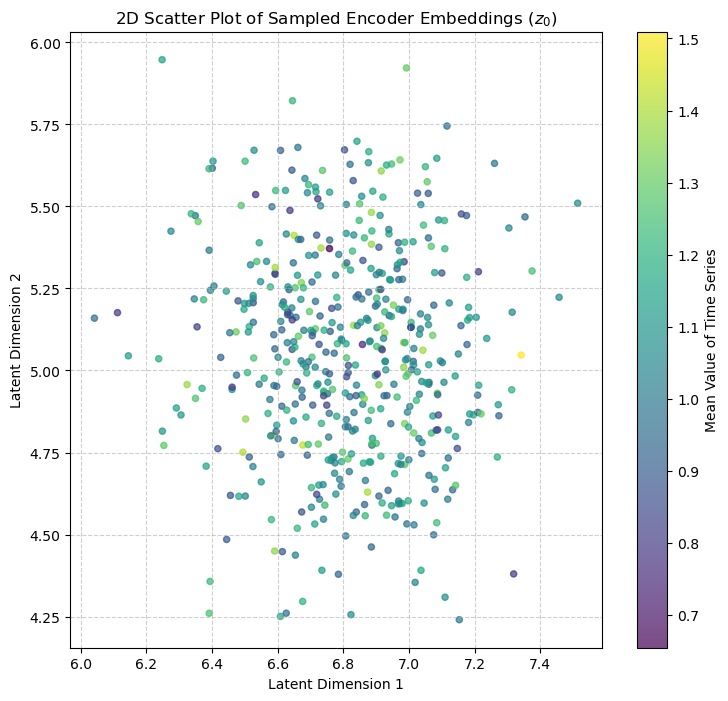

In [62]:
# ==========================================
# EXTRACT AND VISUALIZE ENCODER EMBEDDINGS
# ==========================================

print("Extracting embeddings for all test samples...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode

# Lists to store results from each batch
all_embeddings = []
all_series_means = [] # To store a property of each time series for coloring

# Create an infinite generator for the test loader
dataloader_inf = utils.inf_generator(test_loader)
n_batches = len(test_loader)

with torch.no_grad():
    for i in range(n_batches):
        # Get the next batch of data
        batch_dict = next(dataloader_inf)
        
        # Get model reconstructions and the info dictionary containing latent info
        _, info = model.get_reconstruction(
            time_steps_to_predict=batch_dict["tp_to_predict"], 
            truth=batch_dict["observed_data"], 
            truth_time_steps=batch_dict["observed_tp"],
            mask=batch_dict["observed_mask"],
            n_traj_samples=1
        )
        
        # The 'first_point' key in the info dict contains the tuple (mean, std, sample) for z0
        first_point_info = info.get("first_point")
        if first_point_info and first_point_info[2] is not None:
            # Extract the sampled z0, which is the embedding
            # Squeeze the sample dimension (which is 1) and move to CPU
            sampled_z0 = first_point_info[2].squeeze(0).cpu()
            all_embeddings.append(sampled_z0)

            # Here you can access other parts of the batch, like time steps
            # For this example, we'll get a property of the ground truth data for visualization
            ground_truth_data = batch_dict["data_to_predict"].cpu()
            series_mean = ground_truth_data.mean(dim=(1, 2))  # Calculate mean value over time and features
            all_series_means.append(series_mean)

# Concatenate results from all batches into single tensors
if all_embeddings:
    embeddings_sampled = torch.cat(all_embeddings, dim=0).numpy()
    series_means = torch.cat(all_series_means, dim=0).numpy()
    
    print(f"\nSuccessfully extracted embeddings for {embeddings_sampled.shape[0]} test samples.")
    print(f"Embedding dimension: {embeddings_sampled.shape[1]}")

    # --- Visualize the embeddings (first two dimensions) ---
    plt.figure(figsize=(9, 8))
    scatter = plt.scatter(
        embeddings_sampled[:, 0], 
        embeddings_sampled[:, 1], 
        alpha=0.7, 
        s=20,
        c=series_means,  # Color points by the mean value of the time series
        cmap='viridis'
    )
    plt.title("2D Scatter Plot of Sampled Encoder Embeddings ($z_0$)")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Add a color bar to show what the colors represent
    cbar = plt.colorbar(scatter)
    cbar.set_label("Mean Value of Time Series")

    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()
else:
    print("Could not extract embeddings.")

In [89]:
time_steps_to_predict=batch_dict["tp_to_predict"]
truth=batch_dict["observed_data"]
truth_time_steps=batch_dict["observed_tp"]
mask=batch_dict["observed_mask"]
n_traj_samples=1

In [90]:
truth_w_mask = torch.cat((truth, mask), -1)

In [120]:
first_point_mu, first_point_std = model.encoder_z0(truth_w_mask, truth_time_steps, run_backwards=True)
means_z0 = first_point_mu.repeat(n_traj_samples, 1, 1)
sigma_z0 = first_point_std.repeat(n_traj_samples, 1, 1)
first_point_enc = utils.sample_standard_gaussian(means_z0, sigma_z0)
first_point_enc_aug = first_point_enc
means_z0_aug = means_z0

In [121]:
sol_y = model.diffeq_solver(first_point_enc_aug, time_steps_to_predict)

In [127]:
pred_x = model.decoder(sol_y)

In [134]:
pred_x[0][0].detach().cpu().numpy().shape

(50, 1)

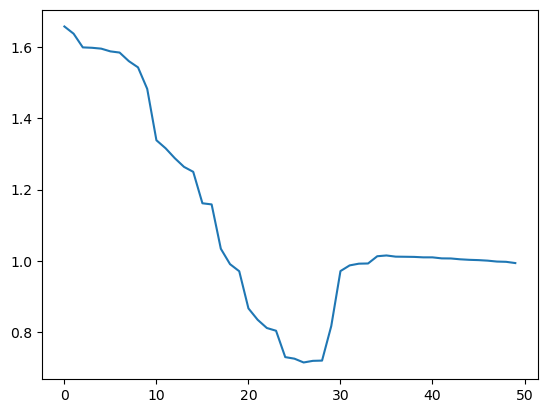

In [135]:
plt.plot(pred_x[0][0].detach().cpu().numpy())